## VAE method for Motion prediction

## Import libraries

In [1]:
# torch imports
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.models.resnet import resnet50, resnet18, resnet34, resnet101
import torch.functional as F

# l5kit imports
import l5kit
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory

# common imports
import os
import random
import time
import pandas as pd
from typing import Dict
from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from prettytable import PrettyTable
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [2]:
l5kit.__version__

'1.1.0'

In [3]:
torch.cuda.is_available()

False

## Helper functions

In [4]:
DIR_INPUT = '/Users/angel/GitHub/l5kit'
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)
VALIDATION = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
cfg = {
    'format_version': 4,
    'model_params': {
        'model_architecture': 'resnet18',
        
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1
    },
    
    'raster_params': {
        'raster_size': [1, 1],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },
    
    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 32,
        'shuffle': True,
        'num_workers': 8
    },
    
    'val_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 8
    },
    
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 8
    },
    
    'train_params': {
        'checkpoint_every_n_steps': 1000,
        'max_num_steps': 10000,
        'eval_every_n_steps': 500
    }
}

In [18]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)

# Train dataset/dataloader
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset,
                              shuffle=train_cfg["shuffle"],
                              batch_size=train_cfg["batch_size"],
                              num_workers=train_cfg["num_workers"])

print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [19]:
# ===== INIT  VAL DATASET
val_cfg = cfg["val_data_loader"]

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)

# Train dataset/dataloader
val_zarr = ChunkedDataset(dm.require(val_cfg["key"])).open()
val_dataset = AgentDataset(cfg, val_zarr, rasterizer)
val_dataloader = DataLoader(val_dataset,
                              shuffle=val_cfg["shuffle"],
                              batch_size=val_cfg["batch_size"],
                              num_workers=train_cfg["num_workers"])

print(val_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  4030296   | 312617887  |    29277930   |      111.97     |        248.48        |        77.57         |        24.85         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


### LSTM Encoder Decoder

In [20]:
class EncoderLSTM(nn.Module):
    
    def __init__(self, cfg, nz):
        super(EncoderLSTM, self).__init__()
        
        self.input_sz  = 2
        self.hidden_sz = nz
        self.num_layer = 1 # maybe 50
        
        self.Encoder_lstm = nn.LSTM(self.input_sz,self.hidden_sz,self.num_layer,batch_first=True)
       
    def forward(self,inputs):
        
        output,hidden_state = self.Encoder_lstm(inputs)
        
        return output,hidden_state
    
class DecoderLSTM(nn.Module):
    def __init__(self, cfg, nz):
        super(DecoderLSTM, self).__init__()
        
        self.input_sz  = nz
        self.hidden_sz = nz
        self.hidden_sz_en = nz
        self.num_layer = 1 # maybe 50
        self.sequence_len_de = 1
        
        self.interlayer = nz * 4

        num_targets = 2 * cfg["model_params"]["future_num_frames"]
        
        self.Decoder_lstm = nn.LSTM( self.input_sz,self.hidden_sz,self.num_layer,batch_first=True)
        
        self.fcn_en_state_dec_state= nn.Sequential(nn.Linear(in_features=self.hidden_sz_en, out_features=self.interlayer),
                            nn.ReLU(inplace=True),
                            nn.Linear(in_features=self.interlayer, out_features=num_targets))

    def forward(self,inputs, hidden_state, z):
        inout_to_dec = torch.ones(inputs.shape[0],self.sequence_len_de,self.input_sz).to(device)

        #for i in range(cfg["model_params"]["future_num_frames"]+1): # this can be used to feed output from previous LSTM to anther one which is stacked.
        decoder_output = self.Decoder_lstm(inout_to_dec,(hidden_state.contiguous(),z.contiguous()))
                        
        inout_to_dec = decoder_output[0]
        
        fc_out = self.fcn_en_state_dec_state (inout_to_dec.squeeze(dim=0))
        
        return fc_out.reshape(inputs.shape[0],cfg["model_params"]["future_num_frames"],-1)

In [21]:
def kl_divergence(mu1, log_sigma1, mu2, log_sigma2):
  """Computes KL[p||q] between two Gaussians defined by [mu, log_sigma]."""
  return (log_sigma2 - log_sigma1) + (torch.exp(log_sigma1) ** 2 + (mu1 - mu2) ** 2) \
               / (2 * torch.exp(log_sigma2) ** 2) - 0.5


class VAE(nn.Module):
  def __init__(self, nz, cfg, beta=0.1):
    super().__init__()
    self.beta = beta          # factor trading off between two loss components
    self.cfg = cfg

    self.encoder = EncoderLSTM(cfg, nz * 2)
    self.decoder = DecoderLSTM(cfg, nz)

  def reparameterize(self, mu, logvar):   
      if self.training:
        std = torch.exp(logvar)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + (std * esp)
        return z
      else:
        return mu

  def forward(self, inputs):
    # encode input into posterior distribution q(z | x)
    _,hidden_state = self.encoder(inputs)

    hidden_state_zero_reshaped = hidden_state[0].squeeze(0)
    hidden_state_one_reshaped = hidden_state[1].squeeze(0)

    mu0 = hidden_state_zero_reshaped[:,:nz]
    logvar0 = hidden_state_zero_reshaped[:,nz:]

    mu = hidden_state_one_reshaped[:,:nz]
    logvar = hidden_state_one_reshaped[:,nz:]

    q = {}
    q['mean'] = mu
    q['log_sigma'] = logvar

    # sample latent variable z with reparametrization
    z0 = self.reparameterize(mu0, logvar0)

    z = self.reparameterize(mu, logvar) # batch of sampled embeddings
        
    # compute reconstruction
    reconstruction = self.decoder(inputs, z0.unsqueeze(0), z.unsqueeze(0))

    return {'q': q, 
          'rec': reconstruction}

  def loss(self, x, outputs, target_availabilities):
    # compute reconstruction loss    
    loss = nn.MSELoss(reduction='none')

    rec_loss = loss(outputs['rec'], x)
    rec_loss = rec_loss * target_availabilities

    mu = outputs['q']['mean']
    log_sigma = outputs['q']['log_sigma']

    mu2 = torch.zeros_like(mu).to(device)
    log_sigma2 = torch.zeros_like(log_sigma).to(device)
    kl_loss = torch.mean(kl_divergence(mu, log_sigma, mu2, log_sigma2))

    return rec_loss + self.beta * kl_loss, \
           {'rec_loss': rec_loss, 'kl_loss': kl_loss}

    
  def reconstruct(self, x):
    """Use mean of posterior estimate for visualization reconstruction."""
    reconstruction = self.forward(x)['rec']
    return reconstruction

In [22]:
# ==== INIT MODEL
nz = 128
learning_rate = 1e-3

model = VAE(nz, cfg, beta=0.2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.0005)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=7000,gamma=0.1)
criterion = nn.MSELoss(reduction="none")

In [23]:
import pdb
# ==== TRAIN LOOP
tr_it = iter(train_dataloader)
vl_it = iter(val_dataloader)

progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
losses_mean_train = []
rec_loss, kl_loss = [], []
losses_val = []
losses_mean_val = []

for itr in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)

    history_positions = data['history_positions'].to(device)
    history_availabilities = data['history_availabilities'].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets_position = data["target_positions"].to(device)

    outputs = model(history_positions)
    loss, losses = model.loss(targets_position, outputs, target_availabilities)
    rec_loss.append(losses['rec_loss'].mean())
    kl_loss.append(losses['kl_loss'].mean())
    total_loss = losses['rec_loss'] + losses['kl_loss']
    loss = total_loss.mean()
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses_train.append(total_loss.mean().item())
    losses_mean_train.append(np.mean(losses_train))
    
    with open('VaeConfigA_train.csv','a') as fd:
        fd.write(f"{itr},{loss}\n")
        
    with open('VaeConfigA__train_avg.csv','a') as fd:
        fd.write(f"{itr},{np.mean(losses_train)}\n")
    
    # Validation
    if VALIDATION :
        with torch.no_grad():
            try:
                val_data = next(vl_it)
            except StopIteration:
                vl_it = iter(val_dataloader)
                val_data = next(vl_it)

            model.eval()
            # Forward pass
            target_availabilities_val = val_data["target_availabilities"].unsqueeze(-1).to(device)
            targets_positions_val = val_data["target_positions"].to(device)
            history_positions_val = val_data['history_positions'].to(device)
            history_availabilities_val = val_data['history_availabilities'].to(device)

            outputs_val = model(history_positions_val)
                    
            loss_v, losses_v = model.loss(targets_positions_val, outputs_val, target_availabilities_val)
            loss_v = loss_v.mean()
            total_loss_val = losses_v['rec_loss'] + losses_v['kl_loss']
            losses_val.append(total_loss_val.mean().item())
            losses_mean_val.append(np.mean(losses_val))


        desc = f" TrainLoss: {round(loss.item(), 4)} ValLoss: {round(total_loss_val.mean().item(), 4)} TrainMeanLoss: {np.mean(losses_train)} ValMeanLoss: {np.mean(losses_val)}" 
    else:
        desc = f" TrainLoss: {round(loss.item(), 4)}"
        
    if (itr+1) % 250 == 0:
            torch.save(model.state_dict(), f'VAEConfigA.pth')

    lr_scheduler.step()

    progress_bar.set_description(desc)

 TrainLoss: 2.7087: 100%|██████████| 10000/10000 [47:58<00:00,  3.47it/s]  


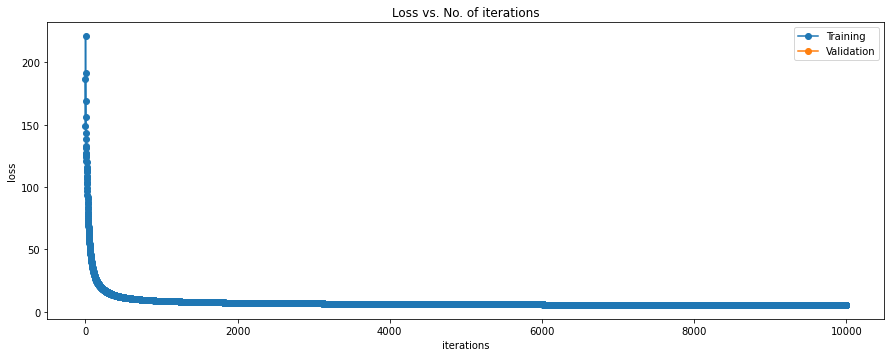

In [24]:
def plot_losses(train, val):
    plt.subplot(2, 1, 1)
    plt.plot(train, '-o')
    plt.plot(val, '-o')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of iterations');
    plt.gcf().set_size_inches(15, 12)

plot_losses(losses_mean_train, losses_mean_val)

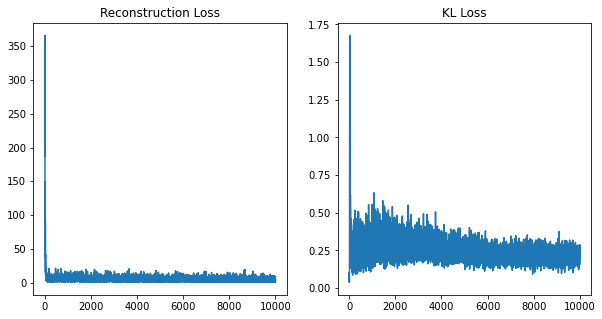

In [25]:
def plot_losses(rec_loss, kl_loss):
    fig = plt.figure(figsize = (10, 5))
    ax1 = plt.subplot(121)
    ax1.plot(rec_loss)
    ax1.title.set_text("Reconstruction Loss")
    ax2 = plt.subplot(122)
    ax2.plot(kl_loss)
    ax2.title.set_text("KL Loss")
    plt.show()

plot_losses(rec_loss, kl_loss)

In [26]:
# ===== INIT DATASET
test_cfg = cfg["test_data_loader"]

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)

# Test dataset/dataloader
test_zarr = ChunkedDataset(dm.require(test_cfg["key"])).open()
test_dataset = AgentDataset(cfg, test_zarr, rasterizer)
test_dataloader = DataLoader(test_dataset,
                             shuffle=test_cfg["shuffle"],
                             batch_size=test_cfg["batch_size"],
                             num_workers=test_cfg["num_workers"])


model.load_state_dict(torch.load('VAEConfigA.pth'))
print(test_dataloader)

In [27]:
print(len(test_dataloader))

185990


In [31]:
losses_test = []
losses_mean_test = []
itr = 0

model.eval()
with torch.no_grad():
    dataiter = tqdm(test_dataloader)
    
    for data in dataiter:
        history_positions = data['history_positions'].to(device)
        history_availabilities = data['history_availabilities'].to(device)
        target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
        targets_position = data["target_positions"].to(device)
        
        outputs = model(history_positions)
        _, losses = model.loss(targets_position, outputs, target_availabilities)
        total_loss = losses['rec_loss'] + losses['kl_loss']
        loss = total_loss.mean()
        
        losses_test.append(loss.item())
        losses_mean_test.append(np.mean(losses_test))
        
        with open('VaeConfigA_test.csv','a') as fd:
            fd.write(f"{itr},{loss}\n")
        
        with open('VaeConfigA__test_avg.csv','a') as fd:
            fd.write(f"{itr},{np.mean(losses_test)}\n")

        itr += 1
        if itr == 1000:
            break

  1%|          | 999/185990 [04:16<13:11:41,  3.89it/s]


In [32]:
print(f"Mean Test Loss: {np.mean(losses_test)}")

Mean Test Loss: 2.1585916013121604


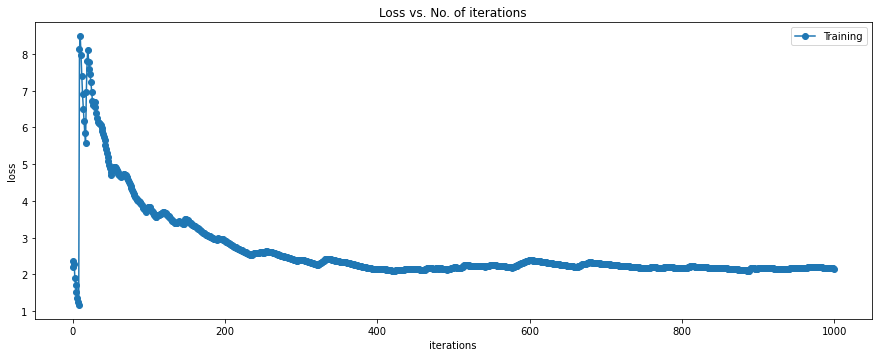

In [33]:
def plot_losses(train):
    plt.subplot(2, 1, 1)
    plt.plot(train, '-o')
#     plt.plot(val, '-o')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of iterations');
    plt.gcf().set_size_inches(15, 12)

plot_losses(losses_mean_test)